In [1]:
import os
#External deps
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc,logfbank
from tqdm import tqdm
from shutil import rmtree

from project_constants import TRAINING_CSV_FILENAME,TRAINING_DIR
from project_constants import getPath, getFilesFromDir
from project_constants import OUTPATH as SORTED_SAMPLES


In [2]:
#FUNCTIONS
#Seth Adams audio classification youtube tutorial
def plot_signals(signals):
    #plot vars
    nrows = 2
    ncols = len(signals.keys())//nrows

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharex=False,
    sharey = True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(nrows):
        for y in range(ncols):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

def plot_fft(fft):
    #plot vars
    nrows = 2
    ncols = len(fft.keys())//nrows

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharex=False,
    sharey = True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(nrows):
        for y in range(ncols):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

def plot_fbank(fbank):
    nrows = 2
    ncols = len(fbank.keys())//nrows

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharex=False,
    sharey = True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(nrows):
        for y in range(ncols):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
            cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

def plot_mfccs(mfccs):
    nrows = 2
    ncols = len(mfccs.keys())//nrows

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharex=False,
    sharey = True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(nrows):
        for y in range(ncols):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
            cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

def envelope(y,rate,threshold):
    mask = [] #mask our data so that if the signal dies out and becomes irrelevant we ignore it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)



In [3]:
#Loading data
df = pd.read_csv(getPath(TRAINING_DIR,TRAINING_CSV_FILENAME))
df.set_index('path', inplace=True)

#adding extra info
df['rate'] = 0
print(df)
for f in df.index:
    try:
        rate,signal = wavfile.read(f)
        df.at[f,'length'] = signal.shape[0]/rate
        df.at[f,'rate'] = rate
    except:
        print(f"dropped{f}")
        df.drop(index=f)



                                                       label  rate
path                                                              
./outputs/kick/ELX_BTD_kick_mid_sauce.wav               kick     0
./outputs/kick/TS_VIRGO_beatbox_one_shot_voice_...      kick     0
./outputs/kick/JUST_kick_gut_punch.wav                  kick     0
./outputs/kick/RKU_BLN_KICK015.wav                      kick     0
./outputs/kick/RKU_BLN_KICK05.wav                       kick     0
...                                                      ...   ...
./outputs/hat/open_hat/MAT_ZO_hihat_open_15.wav     open_hat     0
./outputs/hat/open_hat/MAT_ZO_hihat_open_01.wav     open_hat     0
./outputs/hat/open_hat/tp_dr_genic_hat_open_laz...  open_hat     0
./outputs/hat/open_hat/SO_JGER_ohh_909.wav          open_hat     0
./outputs/hat/open_hat/fsh2_hat_one_shot_open_c...  open_hat     0

[3391 rows x 2 columns]


/var/folders/pp/k3myc5r95_9dz0rtmw8fkc0h0000gn/T/ipykernel_66351/362189449.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate,signal = wavfile.read(f)
/var/folders/pp/k3myc5r95_9dz0rtmw8fkc0h0000gn/T/ipykernel_66351/362189449.py:10: WavFileWarning: Reached EOF prematurely; finished at 47944 bytes, expected 47952 bytes from header.
  rate,signal = wavfile.read(f)
/var/folders/pp/k3myc5r95_9dz0rtmw8fkc0h0000gn/T/ipykernel_66351/362189449.py:10: WavFileWarning: Reached EOF prematurely; finished at 73412 bytes, expected 73420 bytes from header.
  rate,signal = wavfile.read(f)
/var/folders/pp/k3myc5r95_9dz0rtmw8fkc0h0000gn/T/ipykernel_66351/362189449.py:10: WavFileWarning: Reached EOF prematurely; finished at 653764 bytes, expected 653772 bytes from header.
  rate,signal = wavfile.read(f)
/var/folders/pp/k3myc5r95_9dz0rtmw8fkc0h0000gn/T/ipykernel_66351/362189449.py:10: WavFileWarning: Reached EOF prematurely; finished at 40436 bytes, expected 40444 bytes from header

                                                       label   rate    length
path                                                                         
./outputs/kick/ELX_BTD_kick_mid_sauce.wav               kick  44100  0.485079
./outputs/kick/TS_VIRGO_beatbox_one_shot_voice_...      kick  44100  0.316100
./outputs/kick/JUST_kick_gut_punch.wav                  kick  44100  0.140590
./outputs/kick/RKU_BLN_KICK015.wav                      kick  48000  0.480000
./outputs/kick/RKU_BLN_KICK05.wav                       kick  48000  0.897146
...                                                      ...    ...       ...
./outputs/hat/open_hat/MAT_ZO_hihat_open_15.wav     open_hat  44100  0.561769
./outputs/hat/open_hat/MAT_ZO_hihat_open_01.wav     open_hat  44100  0.957937
./outputs/hat/open_hat/tp_dr_genic_hat_open_laz...  open_hat  44100  0.333401
./outputs/hat/open_hat/SO_JGER_ohh_909.wav          open_hat  44100  0.437506
./outputs/hat/open_hat/fsh2_hat_one_shot_open_c...  open_hat  44

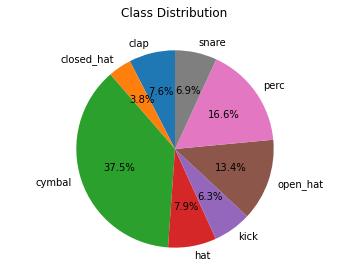

In [4]:
print(df)

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
print(class_dist)

fig,ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
shadow = False, startangle=90) #autopct just means how many D.P
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [5]:
#CONSTANT VARIABLES????? WTF
N_FILT = 26

DOWNSAMPLE = 16000

#FOLDER VARIABLES
DOWNSAMPLEDPATH = "./clean"


dict_keys(['clap', 'closed_hat', 'cymbal', 'hat', 'kick', 'open_hat', 'perc', 'snare'])


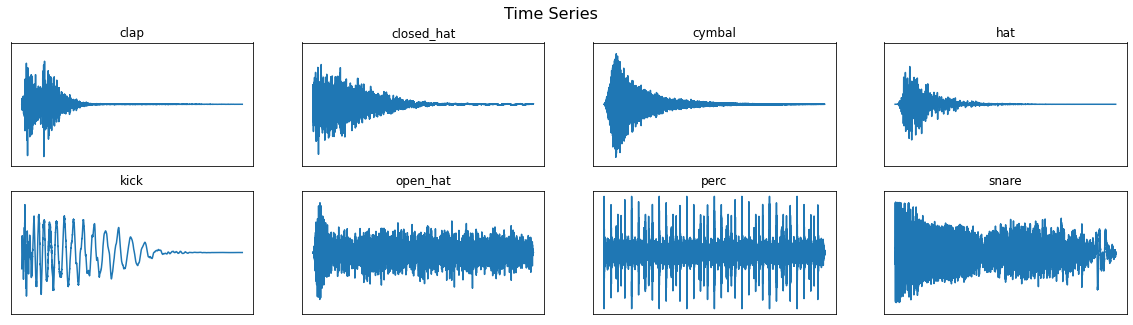

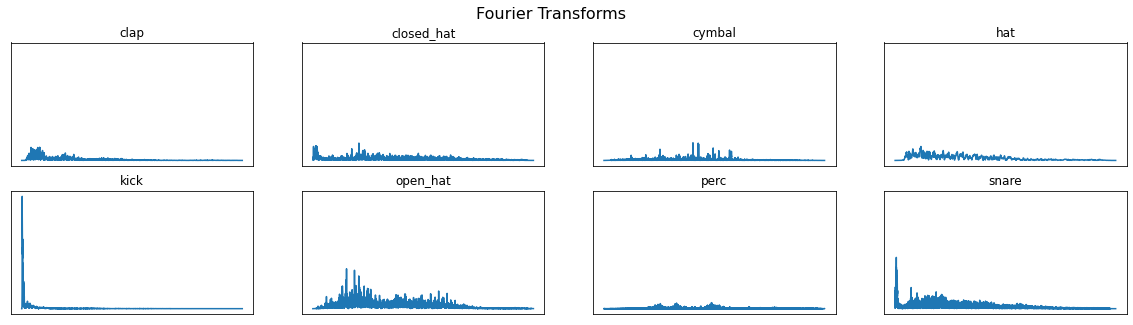

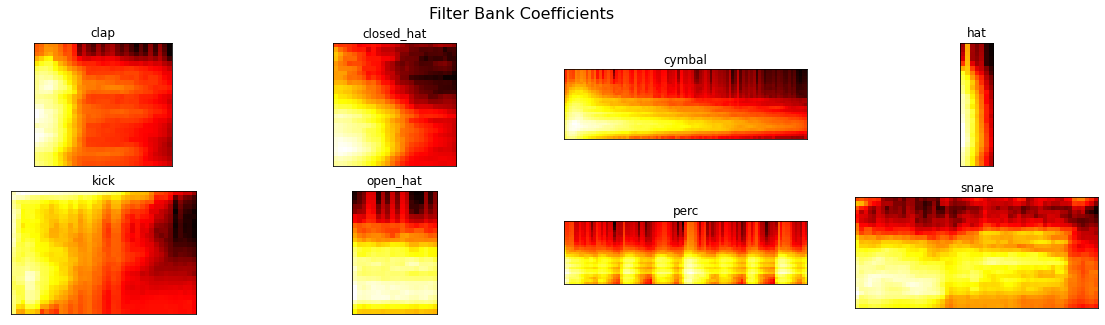

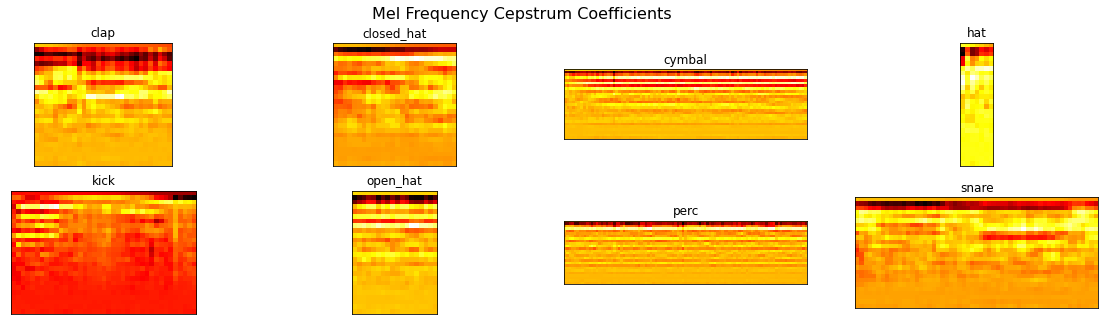

In [6]:

signals = {}
fft = {}
fbank = {}
mfccs = {}



if True == True:
    for c in classes:
        wav_file = df[df.label == c].iloc[0]
        signal, rate = librosa.load(wav_file['path'], sr=wav_file['rate'])
        mask = envelope(signal, rate, 0.0005)
        signal = signal[mask]
        signals[c] = signal
        fft[c] = calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=N_FILT, nfft=rate+1//40).T #nfft should be = to window length when doing short fft
        fbank[c] = bank
        mel = mfcc(signal[:rate],rate, numcep=N_FILT+1//2, nfilt=N_FILT, nfft=rate+1//40).T#numsep is the number of ceptrals we keep after doing discrete cosine transform. typically we throw away half of redundant freqs
        mfccs[c] = mel

print(signals.keys())
plot_signals(signals)
plt.show()
plot_fft(fft)
plt.show()
plot_fbank(fbank)
plt.show()
plot_mfccs(mfccs)
plt.show()

In [7]:
#DOWNSAMPLING - i dont think i want to do this when i actually make genre differences but w/e
rmtree(DOWNSAMPLEDPATH)
os.mkdir(DOWNSAMPLEDPATH)
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.path):
        signal, rate = librosa.load(f, sr=DOWNSAMPLE)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=f"{DOWNSAMPLEDPATH}/{f.split('/')[-1]}", rate=rate, data=signal[mask])

100%|██████████| 3391/3391 [02:04<00:00, 27.13it/s]
